<a href="https://colab.research.google.com/github/uzair-suria/piaic-dl-assignments/blob/main/%20piaic-dl-assignments/multi-classification-flowers/piaic_flowers_recognition_multi_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi Classification Problem: Flower Recognition


## Assignment: Flowers Recognition


**Dataset Description:**

This dataset contains 4242 images of flowers.
The data collection is based on the data flicr, google images, yandex images.
You can use this datastet to recognize plants from the photo.

**Attribute Information:**

The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels.

<b>Also explore how to resize images in tensorflow and then resize all the images to a same size. </b> 

This is a Multiclass Classification Problem.




## Workflow

1. Load Data
2. Split into 60 and 40 ratio
3. Encode labels
4. Create Model
5. Compilation Step (Note : Its a Multiclass
6. Classification problem , select loss , metrics according to it)
7. Train the Model
8. If the model gets overfit tune your model by changing the units , No. of layers , epochs , add dropout layer or add Regularizer according to the need.
9. Prediction should be > 85%
10. Evaluation Step
11. Prediction




**Dataset**

[GDrive](https://drive.google.com/file/d/1-OX6wn5gA-bJpjPNfSyaYQLz-A-AB_uj/view?usp=sharing) | [Kaggle](https://www.kaggle.com/alxmamaev/flowers-recognition)

# Solution

## Loading Data

In [1]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import models, layers
from keras.applications import ResNet50

In [2]:
from google.colab import files

!pip install -q kaggle

### Kaggle API
Upload kaggle API file (`kaggle.json`)

In [3]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
!mv kaggle.json ~/.kaggle/

### Fetch Data from Kaggle

In [6]:
!kaggle datasets download -d alxmamaev/flowers-recognition

flowers-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!ls

flowers  flowers-recognition.zip  sample_data


### Extracting Data


In [3]:
zip_ref = zipfile.ZipFile('./flowers-recognition.zip', 'r')
zip_ref.extractall('./flowers')
zip_ref.close()

In [2]:
dataset_base = 'flowers/flowers'
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

### Load File Names

In [3]:
fnames = []
for cat in categories:
  flower_folder = os.path.join(dataset_base, cat)
  file_names = os.listdir(flower_folder)
  full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
  fnames.append(full_path)

In [4]:
print(f'Length for each category: {[len(f) for f in fnames]}')

Length for each category: [769, 1055, 784, 734, 984]


In [5]:
print(f'Total images: {sum([len(f) for f in fnames])}')

Total images: 4326


### Load Images

In [6]:
images = []
for names in fnames:
  one_cat_imgs = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
  images.append(one_cat_imgs)

In [7]:
print(f'Number of images in each Category: {[len(f) for f in images]}')

Number of images in each Category: [769, 1052, 784, 734, 984]


### Resizing Images

Figure out minimum dimensions of each category

In [8]:
for i, imgs in enumerate(images):
  shapes = [img.shape for img in imgs]
  widths = [shape[0] for shape in shapes]
  heights = [shape[1] for shape in shapes]
  print(f'For {categories[i]} minimum width is {np.min(widths)} and minimum height is {np.min(heights)}')

For daisy minimum width is 125 and minimum height is 134
For dandelion minimum width is 98 and minimum height is 134
For rose minimum width is 80 and minimum height is 150
For sunflower minimum width is 134 and minimum height is 152
For tulip minimum width is 134 and minimum height is 134


Since `cv2` reads images in BGR format, we need to convert it to RGB so that it can be viewed using `plt.imshow()`

For this purpose, a function is defined

In [9]:
def cv2RGB(img):
  return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

### Plot Sample From Each Category

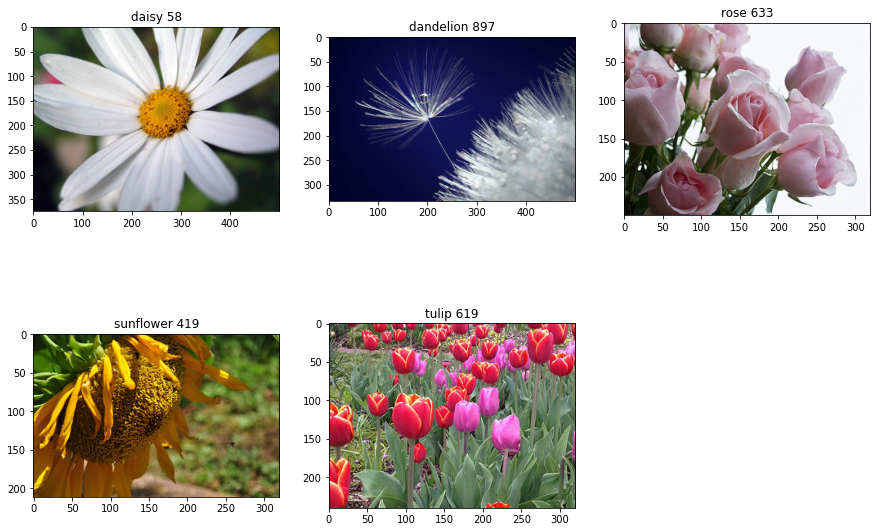

In [10]:
plt.figure(figsize=(15, 10))
for i, imgs in enumerate(images):
  plt.subplot(2, 3, i+1)
  idx = np.random.randint(len(imgs))
  plt.imshow(cv2RGB(imgs[idx]))
  plt.grid(False)
  plt.title(f'{categories[i]} {str(idx)}')
plt.show()

In [11]:
from google.colab.patches import cv2_imshow

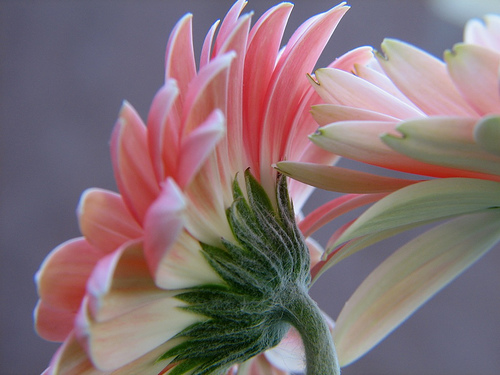

In [12]:
cv2_imshow(images[0][206])

In [13]:
# cv2_imshow(cv2.cvtColor(images[0][206], cv2.COLOR_BGR2GRAY))

In [14]:
# plt.imshow(cv2.cvtColor(images[0][206], cv2.COLOR_BGR2GRAY), cmap='gray')
# plt.grid(False)

Since the neural network is to be trained using graysclad images, the data is converted to grayscale

In [15]:
for cat, imgs in enumerate(images):
  print(len(images[cat]))

769
1052
784
734
984


In [16]:
def BGR2GRAY(images):
  gray_images = []
  for cat, imgs in enumerate(images):
    cat_gray = []
    for img in imgs:
      cat_gray.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    gray_images.append(cat_gray)
  return gray_images

In [17]:
images_gs = BGR2GRAY(images)

In [18]:
len(images_gs)

5

In [19]:
for imgs in images_gs:
  print(len(imgs))

769
1052
784
734
984


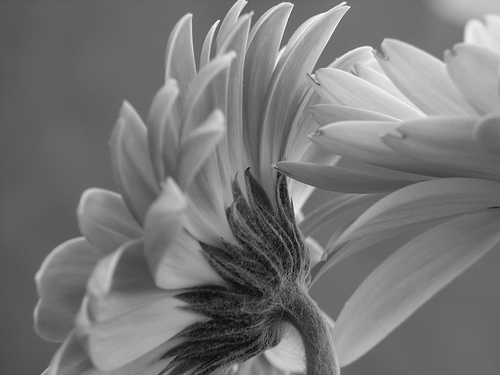

In [20]:
cv2_imshow(images_gs[0][206])

### Resize Images

**Resize single image to required dimensions and review the result**

(375, 500)
(100, 100)


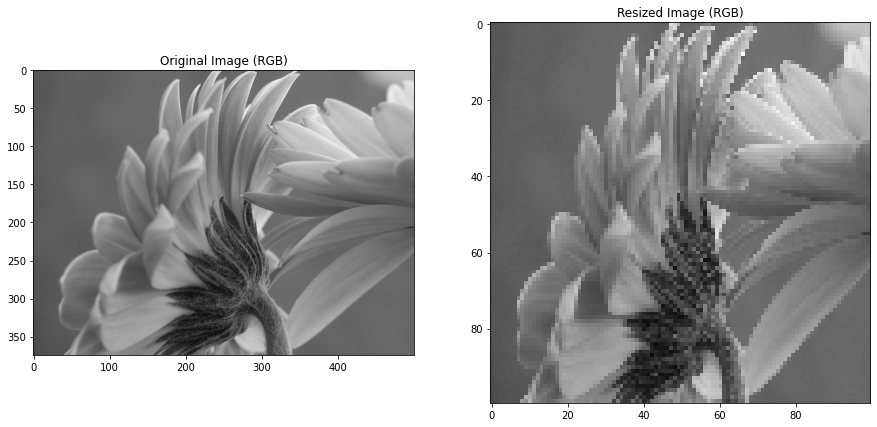

In [21]:
img_width, img_height = 100, 100

sample_img = images_gs[0][206]
print(sample_img.shape)
resized_sample = cv2.resize(sample_img, (img_width, img_height), interpolation=cv2.INTER_CUBIC)
print(resized_sample.shape)
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title('Original Image (RGB)')
plt.imshow(cv2RGB(sample_img))
plt.grid(False)
plt.subplot(1, 2, 2)
plt.title('Resized Image (RGB)')
plt.imshow(cv2RGB(resized_sample))
plt.grid(False)
plt.show()

**Resize all images**

In [22]:
resized_images = []
for i, imgs in enumerate(images_gs):
  resized_images.append([cv2.resize(img, (img_width, img_height), interpolation=cv2.INTER_CUBIC) for img in imgs])

In [23]:
len(resized_images)

5

**View resized images**

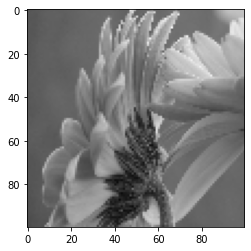

In [24]:
plt.imshow(cv2RGB(resized_images[0][206]))
plt.show()

In [25]:
resized_images[0][206].shape

(100, 100)

## Split Data

### Split Images

In [26]:
train_images = []
val_images = []

for imgs in resized_images:
  train, test = train_test_split(imgs, train_size=0.6, test_size=0.4)
  print(len(train), len(test))
  train_images.append(train)
  val_images.append(test)

461 308
631 421
470 314
440 294
590 394


In [27]:
[len(imgs) for imgs in train_images]

[461, 631, 470, 440, 590]

In [28]:
[len(imgs) for imgs in val_images]

[308, 421, 314, 294, 394]

### Create Labels

In [29]:
len_train_images = [len(imgs) for imgs in train_images]
len_val_images = [len(imgs) for imgs in val_images]

print('Labelling Train Images...')
print(len_train_images)
print(f'Sum of train_images: {np.sum(len_train_images)}')
train_cats = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
  if i is 0:
    print(f'CAT {i} of Train Images range from 0 to {len_train_images[i]}')
    train_cats[:len_train_images[i]] = i
  else:
    train_cats[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])]=i
    print(f'CAT {i} of Train Images range from {np.sum(len_train_images[:i])} to {np.sum(len_train_images[:i+1])}')

print('Labelling Validation Images...')
print(len_val_images)
print(f'Sum of val_images: {np.sum(len_val_images)}')
val_cats = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
  if i is 0:
    print(f'CAT {i} of val Images range from 0 to {len_val_images[i]}')
    train_cats[:len_val_images[i]] = i
  else:
    train_cats[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])]=i
    print(f'CAT {i} of val Images range from {np.sum(len_val_images[:i])} to {np.sum(len_val_images[:i+1])}')

Labelling Train Images...
[461, 631, 470, 440, 590]
Sum of train_images: 2592
CAT 0 of Train Images range from 0 to 461
CAT 1 of Train Images range from 461 to 1092
CAT 2 of Train Images range from 1092 to 1562
CAT 3 of Train Images range from 1562 to 2002
CAT 4 of Train Images range from 2002 to 2592
Labelling Validation Images...
[308, 421, 314, 294, 394]
Sum of val_images: 1731
CAT 0 of val Images range from 0 to 308
CAT 1 of val Images range from 308 to 729
CAT 2 of val Images range from 729 to 1043
CAT 3 of val Images range from 1043 to 1337
CAT 4 of val Images range from 1337 to 1731


### Prepare Data for Deep Learning
1. Convert Image Data to Numpy
2. Convert Labels to Categoricals (one hot encoded)

In [30]:
tmp_train_images = []
tmp_val_images = []

for imgs in train_images:
  tmp_train_images += imgs
for imgs in val_images:
  tmp_val_images += imgs

In [31]:
train_images = np.array(tmp_train_images)
val_images = np.array(tmp_val_images)
print(f'Train Images Data Shape: {train_images.shape}')
print(f'Validation Images Data Shape: {val_images.shape}')

Train Images Data Shape: (2592, 100, 100)
Validation Images Data Shape: (1731, 100, 100)


In [32]:
train_data = train_images.astype('float32')
val_data = val_images.astype('float32')

train_labels = to_categorical(train_cats, len(categories))
val_labels = to_categorical(val_cats, len(categories))

print('Train Data:')
print(f'Train Data Shape: {train_data.shape}')
print(f'Train Labels Shape: {train_labels.shape}')
print('-----------')
print('Validation Data:')
print(f'Validation Data Shape: {val_data.shape}')
print(f'Validation Data Lables: {val_labels.shape}')

Train Data:
Train Data Shape: (2592, 100, 100)
Train Labels Shape: (2592, 5)
-----------
Validation Data:
Validation Data Shape: (1731, 100, 100)
Validation Data Lables: (1731, 5)


### Shuffle Data

In [33]:
for data in [train_data, train_labels, val_data, val_labels]:
  np.random.seed(42)
  np.random.shuffle(data)

___

In [34]:
train_images.shape

(2592, 100, 100)

In [35]:
train_images = train_images.reshape(train_images.shape[0], img_width*img_height)/255
train_images.shape

(2592, 10000)

In [36]:
val_images = val_images.reshape(val_images.shape[0], img_width*img_height)/255
val_images.shape

(1731, 10000)

## Build a Model

In [37]:
model = models.Sequential()

model.add(layers.Dense(8000, activation='relu', input_shape=(img_width*img_height,)))
# model.add(layers.Dense(8192, activation='relu',))
model.add(layers.Dense(4000, activation='relu'))
model.add(layers.Dense(2000, activation='relu'))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8000)              80008000  
_________________________________________________________________
dense_1 (Dense)              (None, 4000)              32004000  
_________________________________________________________________
dense_2 (Dense)              (None, 2000)              8002000   
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2049024   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 122,590,389
Trainable params: 122,590,389
Non-trainable params: 0
__________________________________________

In [39]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [40]:
history = model.fit(train_images, train_labels,
                    batch_size=128, epochs=100, 
                    validation_data=(val_images, val_labels))

Epoch 1/100
21/21 [==============================] - 46s 2s/step - loss: 15.7323 - acc: 0.2816 - val_loss: 2.5201 - val_acc: 0.0000e+00
Epoch 2/100
21/21 [==============================] - 45s 2s/step - loss: 1.5391 - acc: 0.3713 - val_loss: 2.0779 - val_acc: 0.0000e+00
Epoch 3/100
21/21 [==============================] - 44s 2s/step - loss: 1.5090 - acc: 0.3900 - val_loss: 2.0739 - val_acc: 0.0000e+00
Epoch 4/100
21/21 [==============================] - 44s 2s/step - loss: 1.5098 - acc: 0.3743 - val_loss: 1.9958 - val_acc: 0.0000e+00
Epoch 5/100
21/21 [==============================] - 44s 2s/step - loss: 1.5182 - acc: 0.3789 - val_loss: 1.9934 - val_acc: 0.0000e+00
Epoch 6/100
21/21 [==============================] - 48s 2s/step - loss: 1.4948 - acc: 0.3774 - val_loss: 1.9869 - val_acc: 0.0000e+00
Epoch 7/100
21/21 [==============================] - 44s 2s/step - loss: 1.5052 - acc: 0.3783 - val_loss: 2.0308 - val_acc: 0.0000e+00
Epoch 8/100
21/21 [==============================] - 4

In [42]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

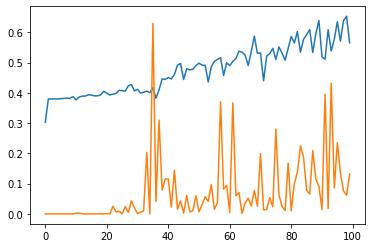

In [47]:
plt.plot(np.arange(len(history.history['acc'])), history.history['acc'])
plt.plot(np.arange(len(history.history['val_acc'])), history.history['val_acc'])

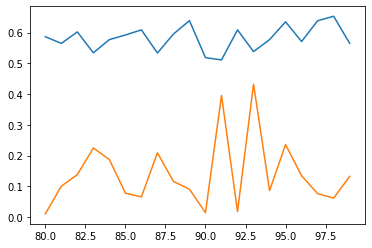

In [48]:
plt.plot(np.arange(len(history.history['acc']))[80:], history.history['acc'][80:])
plt.plot(np.arange(len(history.history['val_acc']))[80:], history.history['val_acc'][80:])

## Evaluation

In [49]:
model.evaluate(val_images, val_labels)

55/55 [==============================] - 10s 189ms/step - loss: 3.5805 - acc: 0.1323


[3.580481767654419, 0.1322934776544571]

## Prediction

In [50]:
preds = model.predict(val_images)

In [51]:
preds

array([[9.76942014e-03, 4.93538454e-02, 1.82097740e-02, 3.55610877e-01,
        5.67056060e-01],
       [3.43838450e-03, 2.69766096e-02, 8.22098181e-03, 3.01644504e-01,
        6.59719527e-01],
       [1.23071454e-01, 2.33676285e-01, 1.29439771e-01, 3.42903316e-01,
        1.70909151e-01],
       ...,
       [1.40876854e-02, 6.19060360e-02, 2.42320150e-02, 3.80915433e-01,
        5.18858850e-01],
       [7.69241378e-02, 1.70344844e-01, 8.80867243e-02, 4.07817364e-01,
        2.56826967e-01],
       [8.02873750e-04, 8.12382717e-03, 2.07306398e-03, 1.16894074e-01,
        8.72106194e-01]], dtype=float32)